First contact with the data. Looking at the visual classification task.

In [43]:
%matplotlib inline
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
from matplotlib.ticker import StrMethodFormatter

In [44]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import validation_curve, learning_curve

In [45]:
def plot_bin_scores(scores, ax):
    gb = scores.groupby(by="bin", as_index=False)
    scores_mean = gb.mean()["acc"]
    scores_std = gb.std()["acc"]
    num_bins = len(scores_mean)
    x = np.arange(num_bins)
    ax.plot(x, scores_mean)
    ax.fill_between(x, scores_mean - scores_std, 
                    scores_mean + scores_std, alpha=0.15)
    ax.set_xlabel('Bin number')
    ax.set_ylabel('Accuracy')
    ax.grid()
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))
    return ax, scores_mean

## How data can be binned:

100 bins per trial, 20 ms averaged per bin. That means, bins 1 to 100 correspond to the first trial, 101 to 200 to the second, and so on. The difference taking one bin or the other is how far we are from onset. For the visual part, there are 79 trials in the data, onset is at bin 20, and the epoch is 2s.

## Sensor numbers

The header numbers indicate if the sensor is a magnetometer, ends in 1, or a gradiometer, ends in 2 or 3.

Reading and cleaning.

In [46]:
!ls data/visual

old_s1	p22_bins20ms  p24_20ms	   p27	     p27_movcorr
p22	p24	      p24_movcorr  p27_20ms


Some more info about the sensors,

- The first two **EOG** should be sensible to eye movement or blinking. They could be regressed out of the time series like movement in fMRI. They can also be used to check if they improve the accuracy notably classifying with or without them.
- Sensors called **CHIP** are there for movement correction and can be discarded for the analysis.
- From sensor **MEG1521** onwards, the sensors are all in the posterior. This is key to be sure all signal associated with eye movement is removed and is not interfering with the classification task.

In [47]:
participant = 'p27_movcorr'
n_trials = 79
session = '1st_session'
# ve0_file = 'data/visual/{}/VE0_allbins_{}.txt'.format(participant, session)
# ve1_file = 'data/visual/{}/VE1_allbins_{}.txt'.format(participant, session)

In [48]:
ve0_file = glob('data/visual/{}*/VE0*{}*'.format(participant, session))
ve1_file = glob('data/visual/{}*/VE1*{}*'.format(participant, session))

In [49]:
ve0 = pd.read_csv(*ve0_file, header=None).transpose()
new_header = ve0.iloc[0]
ve0 = ve0[1:]
ve0.columns = new_header
# 'EOG002', 'EOG003', 
ve0 = ve0.drop(['EOG002', 'EOG003', 'STI016', 'STI101', 'STI102', 'SYS101', 'SYS201', 
                'CHPI001', 'CHPI002', 'CHPI003', 'CHPI004', 'CHPI005',
                'CHPI006', 'CHPI007', 'CHPI008', 'CHPI009'],
                axis=1)
ve0 = ve0.apply(pd.to_numeric, errors='ignore')

In [50]:
ve0.head(3)

0       MEG0111       MEG0112       MEG0113       MEG0121       MEG0122  \
1 -2.755694e-13  1.166465e-11  4.036933e-12 -6.279349e-13  3.364556e-12   
2 -8.112601e-14  9.731026e-12  3.877633e-12 -3.548663e-13  1.127485e-12   
3 -9.817515e-14  8.986391e-12  5.522910e-12 -3.631614e-13 -1.228213e-12   

0       MEG0123       MEG0131       MEG0132       MEG0133       MEG0141  \
1  5.604901e-12 -2.903366e-13  1.003538e-11  1.120130e-11  6.751512e-14   
2  4.885346e-12 -9.162917e-14  7.483248e-12  8.576975e-12  1.952099e-13   
3  5.355535e-12 -5.891435e-14  4.675691e-12  9.447835e-12  1.627513e-13   

0      ...            MEG2613       MEG2621       MEG2622       MEG2623  \
1      ...       4.680620e-12  2.568872e-13  3.044305e-12 -2.192275e-12   
2      ...       5.123489e-12  9.591763e-14  1.904267e-12  4.366495e-12   
3      ...       5.286897e-12  6.662454e-15  8.767924e-13  7.261884e-12   

0       MEG2631       MEG2632       MEG2633       MEG2641       MEG2642  \
1  2.251289e-13  2.995076e-13 -1.414023e-12  2.596492e-13  5.607725e-13   
2  1.300139e-13 -2.724072e-12  2.690340e-12  4.430529e-14 -2.278166e-12   
3  1.006919e-13 -3.196564e-12  2.584848e-12 -6.725101e-14 -6.344763e-15   

0       MEG2643  
1  4.311624e-12  
2 -1.745772e-12  
3 -2.840665e-12  

[3 rows x 306 columns]

In [51]:
ve0.shape

(7900, 306)

In [52]:
ve0.columns

Index(['MEG0111', 'MEG0112', 'MEG0113', 'MEG0121', 'MEG0122', 'MEG0123',
       'MEG0131', 'MEG0132', 'MEG0133', 'MEG0141',
       ...
       'MEG2613', 'MEG2621', 'MEG2622', 'MEG2623', 'MEG2631', 'MEG2632',
       'MEG2633', 'MEG2641', 'MEG2642', 'MEG2643'],
      dtype='object', name=0, length=306)

In [53]:
ve1 = pd.read_csv(*ve1_file, header=None).transpose()
new_header = ve1.iloc[0]
ve1 = ve1[1:]
ve1.columns = new_header
# 'EOG002', 'EOG003', 
ve1 = ve1.drop(['EOG002', 'EOG003', 'STI016', 'STI101', 'STI102', 'SYS101', 'SYS201', 
                'CHPI001', 'CHPI002', 'CHPI003', 'CHPI004', 'CHPI005',
                'CHPI006', 'CHPI007', 'CHPI008', 'CHPI009'],
                axis=1)
ve1 = ve1.apply(pd.to_numeric, errors='ignore')

In [54]:
ve1.head(3)

0       MEG0111       MEG0112       MEG0113       MEG0121       MEG0122  \
1  3.542263e-13 -1.976542e-12 -4.939658e-12  4.325592e-13  4.476423e-12   
2  4.508036e-13 -3.718127e-12 -4.109020e-12  5.002443e-13  8.030234e-12   
3  6.993370e-13  7.034714e-12 -2.879998e-12  5.559234e-13  9.131625e-12   

0       MEG0123       MEG0131       MEG0132       MEG0133       MEG0141  \
1  1.954112e-12  4.562981e-13 -4.203564e-13  1.261190e-12  3.265273e-13   
2 -1.019620e-12  4.313896e-13  3.723068e-12 -2.766199e-12  3.485947e-13   
3  5.884890e-12  6.283717e-13  9.342723e-12  2.038688e-12  9.317166e-13   

0      ...            MEG2613       MEG2621       MEG2622       MEG2623  \
1      ...      -3.747396e-12 -1.373301e-13 -6.706909e-13 -1.459414e-12   
2      ...      -4.970991e-12  2.848717e-14 -2.071634e-12 -1.152315e-12   
3      ...       8.220135e-13 -4.851536e-13  6.281296e-12  3.673376e-12   

0       MEG2631       MEG2632       MEG2633       MEG2641       MEG2642  \
1 -1.623710e-13  8.339719e-13  4.409371e-13 -6.400950e-14 -1.737209e-12   
2  3.881877e-14  1.056610e-12 -1.592355e-12  8.171603e-14  2.757272e-12   
3 -7.131440e-13  8.271077e-12  1.161042e-11 -6.223568e-13 -3.806360e-12   

0       MEG2643  
1  6.357036e-13  
2 -3.616951e-12  
3  1.074700e-11  

[3 rows x 306 columns]

In [55]:
ve1.shape

(7900, 306)

In [56]:
# # Compute the correlation matrix
# corr = ve1.corr()

# # Generate a mask for the upper triangle
# mask = np.zeros_like(corr.iloc[2:100, 2:100], dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr.iloc[2:100, 2:100], cmap=cmap, mask=mask,
#             xticklabels=2, yticklabels=2,
#             square=True, cbar_kws={"shrink": .5}, ax=ax)
# _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# _ = ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

In [57]:
bins_per_trial = int(ve0.shape[0] / n_trials)

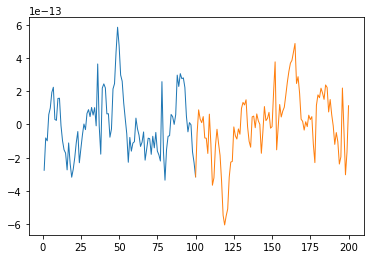

In [58]:
plt.plot(ve0.loc[:bins_per_trial, 'MEG0111'], lw=1)
plt.plot(ve0.loc[bins_per_trial:bins_per_trial*2, 'MEG0111'], lw=1)

In [59]:
timebin_to_take = 5

In [60]:
# X_0 = ve0[timebin_to_take:-1:50]
# X_1 = ve1[timebin_to_take:-1:50]
# ve0.columns.get_loc("MEG1521")
X_0 = ve0.iloc[:, :].values
X_1 = ve1.iloc[:, :].values

In [61]:
X_0 = X_0.reshape(n_trials, bins_per_trial, -1)
X_1 = X_1.reshape(n_trials, bins_per_trial, -1)

In [62]:
# [trial_number, bin, sensor]
print(X_0.shape)
print(X_1.shape)

(79, 100, 306)
(79, 100, 306)


Looks good.

Let's do some classification. Prepare the input matrix and vector.

In [63]:
X = np.vstack((X_0[:, timebin_to_take, :], 
               X_1[:, timebin_to_take, :]))
y = np.repeat([-1, 1], int(X.shape[0] / 2))

In [64]:
# pipeline = make_pipeline(StandardScaler(), 
#                          LogisticRegressionCV(solver='liblinear', penalty='l1',
#                                               n_jobs=10))
pipeline = make_pipeline(
                         StandardScaler(),
                         # PCA(n_components=.99, svd_solver='full'),
                         LogisticRegression(C=1, solver='liblinear', penalty='l1')
                         # GradientBoostingClassifier(n_estimators=2000, learning_rate=0.2,
                         #                            max_depth=3, subsample=0.5)
                         )
cvss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
cvsk = StratifiedKFold(n_splits=10, random_state=42)

In [65]:
lr_grid_params = {
    'logisticregression__C': (1e-2, 1e-2, 1., 10, 100),
    'logisticregression__penalty': ('l1', 'l2')
}

gscv = GridSearchCV(pipeline, lr_grid_params, cv=5)

In [66]:
y_pred = cross_val_predict(pipeline, X, y, cv=cvsk, n_jobs=4)

In [67]:
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

         -1       0.53      0.52      0.52        79
          1       0.53      0.53      0.53        79

avg / total       0.53      0.53      0.53       158



In [68]:
print(confusion_matrix(y, y_pred))

[[41 38]
 [37 42]]


Let's look at clf accuracies with respect to bin number like Kurth-Nelson does

In [69]:
bin_scores = {}
# bins_per_trial = 0
for b in range(bins_per_trial):
    X = np.vstack((X_0[:, b, :], 
                   X_1[:, b, :]))
    y = np.repeat([-1, 1], int(X.shape[0] / 2))
    this_bin_scores = cross_val_score(pipeline, X, y, cv=cvsk, n_jobs=4)
#     this_bin_scores = cross_val_score(gscv, X, y, cv=10)
    bin_scores[b] = this_bin_scores
#     print('bin {}: {:.3%} ACC'.format(
#           b, np.mean(this_bin_scores)))

In [70]:
scores = pd.melt(pd.DataFrame(bin_scores), var_name="bin", value_name="acc")

In [71]:
sorted_scores = (scores
                 .groupby(by="bin", as_index=False)
                 .mean()
                 .sort_values(by='acc', ascending=False)
                 .head(10)
                )

In [72]:
sorted_scores

bin       acc
29   29  0.659821
36   36  0.653571
95   95  0.650893
35   35  0.647321
38   38  0.647321
30   30  0.639286
45   45  0.638393
43   43  0.637500
46   46  0.634821
42   42  0.630357

In [73]:
best_bin = sorted_scores.bin.iloc[0]

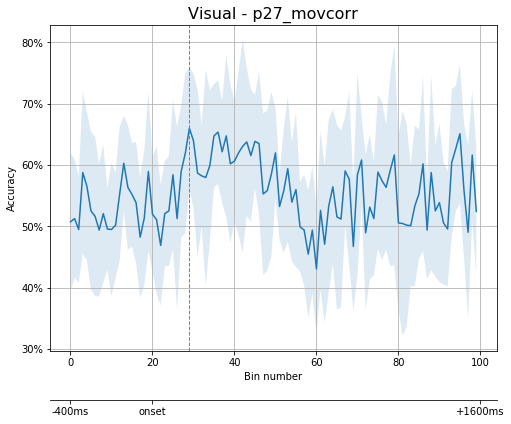

In [74]:
fig, ax = plt.subplots(figsize=(8, 6))
ax, score_means = plot_bin_scores(scores, ax)
ax.set_title('Visual - {}'.format(participant), 
             fontsize=16)
ax2 = ax.twiny()
ax2.plot(range(len(score_means)), score_means, alpha=0)
# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.15))
# Turn on the frame for the twin axis, but then hide all 
# but the bottom spine
ax2.set_frame_on(True)
ax2.patch.set_visible(False)
for sp in ax2.spines.values():
    sp.set_visible(False)
ax2.spines["bottom"].set_visible(True)
ax2.set_xticks([0, 20, 100])
ax2.set_xticklabels(["-400ms", "onset", "+1600ms"])
ax.axvline(best_bin, color='grey', ls='--', lw=1)

Let's look at the best bin.

In [75]:
X = np.vstack((X_0[:, best_bin, :], 
               X_1[:, best_bin, :]))
y = np.repeat([-1, 1], int(X.shape[0] / 2))

## Validation Curve

In [76]:
# possible_cs = np.logspace(-2, 3, 6)
possible_cs = [1e-3, 1e-2, 1e-1, 1, 5, 10, 50, 1e2, 5e2, 1e3]
possible_cs = np.asarray(possible_cs)

In [77]:
train_scores, valid_scores = validation_curve(pipeline, X, y, 
                                              "logisticregression__C",
                                              possible_cs,
                                              cv=cvss,
                                              n_jobs=4)

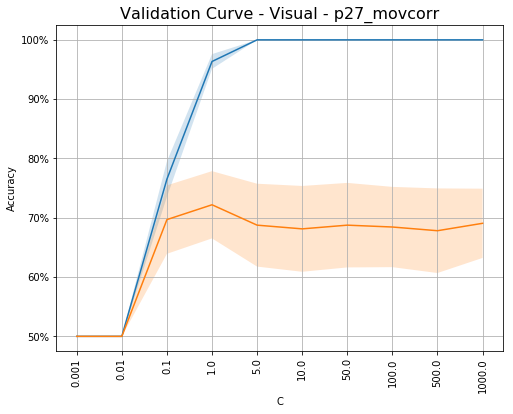

In [78]:
fig, ax = plt.subplots(figsize=(8, 6))
mean_train = train_scores.mean(axis=1)
mean_valid = valid_scores.mean(axis=1)
std_train = train_scores.std(axis=1)
std_valid = valid_scores.std(axis=1)
ax.plot(mean_train)
ax.plot(mean_valid)
x = np.arange(mean_train.size)
ax.fill_between(x, mean_train + std_train, mean_train - std_train, alpha=0.2)
ax.fill_between(x, mean_valid + std_valid, mean_valid - std_valid, alpha=0.2)
ax.set_xticks(range(possible_cs.size))
_ = ax.set_xticklabels(possible_cs, rotation=90)
ax.set_title('Validation Curve - Visual - {}'.format(participant),
             fontsize=16)
ax.set_ylabel('Accuracy')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))
ax.set_xlabel('C')
ax.grid()

## Learning Curve

In [79]:
train_sizes, train_scores, valid_scores = learning_curve(
    pipeline, 
    X, y, 
    train_sizes=np.linspace(.1, 1., num=10), 
    cv=cvss,
    n_jobs=10
)

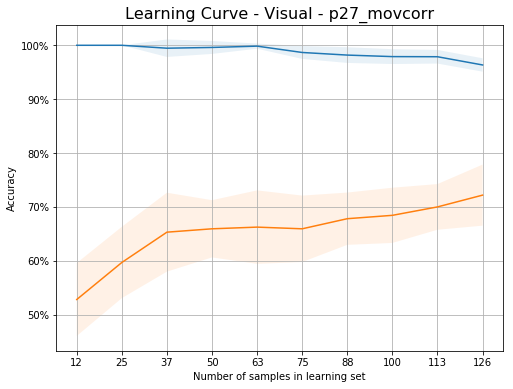

In [80]:
fig, ax = plt.subplots(figsize=(8, 6))
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
valid_mean = valid_scores.mean(axis=1)
valid_std = valid_scores.std(axis=1)
x = range(train_sizes.size)
ax.plot(x, train_mean)
ax.fill_between(x, train_mean + train_std, train_mean - train_std, alpha=0.1)
ax.plot(x, valid_scores.mean(axis=1))
ax.fill_between(x, valid_mean + valid_std, valid_mean - valid_std, alpha=0.1)
ax.set_xticks(x)
_ = ax.set_xticklabels(train_sizes)
ax.set_title('Learning Curve - Visual - {}'.format(participant),
             fontsize=16)
ax.set_ylabel('Accuracy')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))
ax.set_xlabel('Number of samples in learning set')
ax.grid()

In [81]:
y_pred = cross_val_predict(pipeline, X, y, cv=cvsk, n_jobs=4)

In [82]:
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

         -1       0.67      0.65      0.66        79
          1       0.66      0.68      0.67        79

avg / total       0.66      0.66      0.66       158



In [83]:
accuracy_score(y, y_pred)

0.66455696202531644

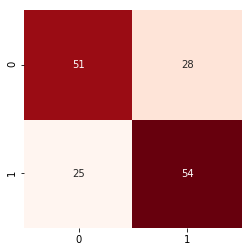

In [84]:
sns.heatmap(confusion_matrix(y, y_pred),
            annot=True, cmap=plt.cm.Reds, cbar=False,
            square=True)

# AVG

    bins_to_avg = 2

    ve0_avg = ve0.values.reshape(int(ve0.shape[0] / bins_to_avg), bins_to_avg, ve0.shape[1])

    ve0_avg = np.average(ve0_avg, axis=1)

    ve0_avg = pd.DataFrame(ve0_avg, columns=ve0.columns)

    ve1_avg = ve1.values.reshape(int(ve1.shape[0] / bins_to_avg), bins_to_avg, ve1.shape[1])
    ve1_avg = np.average(ve1_avg, axis=1)
    ve1_avg = pd.DataFrame(ve1_avg, columns=ve1.columns)

    bin_scores = {}
    bins_per_trial = int(bins_per_trial / bins_to_avg)
    for b in range(bins_per_trial):
        X_0 = ve0_avg.iloc[b::bins_per_trial, ve0_avg.columns.get_loc("MEG1521"):]
        X_1 = ve1_avg.iloc[b::bins_per_trial, ve1_avg.columns.get_loc("MEG1521"):]
    #     X_0 = ve0.iloc[b:-1:50, :ve0.columns.get_loc("EOG003")]
    #     X_1 = ve1.iloc[b:-1:50, :ve1.columns.get_loc("EOG003")]
        y_0 = np.zeros(X_0.shape[0])
        y_1 = np.ones(X_1.shape[0])
        X = np.vstack((X_0, X_1))
        y = np.hstack((y_0, y_1))
        this_bin_scores = cross_val_score(pipeline, X, y, cv=10)
    #     this_bin_scores = cross_val_score(gscv, X, y, cv=10)
        bin_scores[b] = this_bin_scores
    #     print('bin {}: {:.3%} ACC'.format(
    #           b, np.mean(this_bin_scores)))

    scores = pd.melt(pd.DataFrame(bin_scores), var_name="bin", value_name="acc")

    fig, ax = plt.subplots(figsize=(8, 6))
    plot_bin_scores(scores, ax)

    print(X.shape)

    # max_acc = np.max(np.mean(bin_scores, axis=1))
    mean_scores = scores.groupby(by="bin", as_index=False).mean()
    max_acc = np.max(mean_scores["acc"])
    print(max_acc)

    best_bin = mean_scores.loc[mean_scores['acc'].idxmax(), "bin"].astype(int)

    print(best_bin)